<a href="https://colab.research.google.com/github/VOTUANANH01/DS_project/blob/master/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/JJAlmagro/subcellular_localization.git
%cd /content/subcellular_localization/notebook tutorial

!rm -rf /usr/local/lib/python3.7/dist-packages/theano
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
!pip install confusionmatrix
!pip install utils
!pip install metrics_mc

Cloning into 'subcellular_localization'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.
/content/subcellular_localization/notebook tutorial
     \ 13.4 MB 564 kB/s
  Created wheel for Theano: filename=Theano-1.0.5+unknown-py3-none-any.whl size=2667300 sha256=16a4e5f94ff4caa3b0ae5969383b6037e4aea489457604d0986d7072f26885e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9hrq2zc/wheels/d1/38/85/558fc0e4d0c26db812304f163e348fb242767d3ea27da937fe
Successfully built Theano
     | 231 kB 6.1 MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-py3-none-any.whl size=122805 sha256=cab3a3e276655194bcd6dd45383032e399e023511f227fc58774aefff10cce02
  Stored in directory: /tmp/pip-ephem-wheel-cache-stbxiizh/wheels/b6/a5/97/c657632d2b7fcff539623ea56996e09ec3c83c871e25a62cc5
Successfully built Lasagne
ERROR: Could not find a version that satisfies the requirement confusionmatrix (from versions: 0

In [ ]:
# Import all the necessary modules
import os
import sys
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,optimizer=None,device=cpu,floatX=float32"
sys.path.insert(0,'..')
import numpy as np
import theano
import theano.tensor as T
import lasagne
from confusionmatrix import ConfusionMatrix
from utils import iterate_minibatches
import matplotlib.pyplot as plt
import time
import itertools
from metrics_mc import *
from models import *
%matplotlib inline

Building the network
The first thing that we have to do is to define the network architecture. Here we are going to use an input layer, two convolutional layers, a bidirectional LSTM, a dense layer and an output layer. These are the steps that we are going to follow:

1.- Specify the hyperparameters of the network:

In [ ]:
batch_size = 128
seq_len = 400
# seq_len=1000
n_feat = 20
n_hid = 15
n_class = 10
lr = 0.0025
n_filt = 10
drop_prob = 0.5

2.- Define the input variables to our network:



In [ ]:
# We use ftensor3 because the protein data is a 3D-matrix in float32 
input_var = T.ftensor3('inputs')
# ivector because the labels is a single dimensional vector of integers
target_var = T.ivector('targets')
# fmatrix because the masks to ignore the padded positions is a 2D-matrix in float32
mask_var = T.fmatrix('masks')
# Dummy data to check the size of the layers during the building of the network
X = np.random.randint(0,10,size=(batch_size,seq_len,n_feat)).astype('float32')
Xmask = np.ones((batch_size,seq_len)).astype('float32')

3.- Define the layers of the network:



In [ ]:
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# Input layer, holds the shape of the data
l_in = lasagne.layers.InputLayer(shape=(batch_size, None, n_feat), input_var=input_var, name='Input')
print('Input layer: {}'.format(
    lasagne.layers.get_output(l_in, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Mask input layer
l_mask = lasagne.layers.InputLayer(shape=(batch_size, None), input_var=mask_var, name='Mask')
print('Mask layer: {}'.format(
    lasagne.layers.get_output(l_mask, inputs={l_mask: mask_var}).eval({mask_var: Xmask}).shape))

# Shuffle shape to be properly read by the CNN layer
l_shu = lasagne.layers.DimshuffleLayer(l_in, (0,2,1))
print('DimshuffleLayer layer: {}'.format(
    lasagne.layers.get_output(l_shu, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Convolutional layers with different filter size
l_conv_a = lasagne.layers.Conv1DLayer(l_shu, num_filters=n_filt, pad='same', stride=1, 
                                      filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
print('Convolutional layer size 3: {}'.format(
    lasagne.layers.get_output(l_conv_a, inputs={l_in: input_var}).eval({input_var: X}).shape))

l_conv_b = lasagne.layers.Conv1DLayer(l_shu, num_filters=n_filt, pad='same', stride=1, 
                                      filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
print('Convolutional layer size 5: {}'.format(
    lasagne.layers.get_output(l_conv_b, inputs={l_in: input_var}).eval({input_var: X}).shape))

# The output is concatenated
l_conc = lasagne.layers.ConcatLayer([l_conv_a, l_conv_b], axis=1)
print('Concatenated convolutional layers: {}'.format(
    lasagne.layers.get_output(l_conc, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Second CNN layer
l_conv_final = lasagne.layers.Conv1DLayer(l_conc, num_filters=n_filt*2, pad='same', 
                                          stride=1, filter_size=3, 
                                          nonlinearity=lasagne.nonlinearities.rectify)
print('Final convolutional layer: {}'.format(
    lasagne.layers.get_output(l_conv_final, inputs={l_in: input_var}).eval({input_var: X}).shape))

l_reshu = lasagne.layers.DimshuffleLayer(l_conv_final, (0,2,1))
print('Second DimshuffleLayer layer: {}'.format(
    lasagne.layers.get_output(l_reshu, inputs={l_in: input_var}).eval({input_var: X}).shape))

# Bidirectional LSTM layer, we only take the last hidden state (only_return_final)
l_fwd = lasagne.layers.LSTMLayer(l_reshu, num_units=n_hid, name='LSTMFwd', mask_input=l_mask, 
                                 only_return_final=True, nonlinearity=lasagne.nonlinearities.tanh)
l_bck = lasagne.layers.LSTMLayer(l_reshu, num_units=n_hid, name='LSTMBck', mask_input=l_mask, 
                                 only_return_final=True, backwards=True, nonlinearity=lasagne.nonlinearities.tanh)
print('Forward LSTM last hidden state: {}'.format(
    lasagne.layers.get_output(l_fwd, inputs={l_in: input_var, l_mask: mask_var}).eval(
        {input_var: X, mask_var:Xmask}).shape))
print('Backward LSTM hidden state: {}'.format(
    lasagne.layers.get_output(l_bck, inputs={l_in: input_var, l_mask: mask_var}).eval(
        {input_var: X, mask_var:Xmask}).shape))

# Concatenate both layers
l_conc_lstm = lasagne.layers.ConcatLayer([l_fwd, l_bck], axis=1)
print('Concatenated last hidden states: {}'.format(
    lasagne.layers.get_output(l_conc_lstm, inputs={l_in: input_var, l_mask: mask_var}).eval(
        {input_var: X, mask_var:Xmask}).shape))

# Dense layer with ReLu activation function
l_dense = lasagne.layers.DenseLayer(l_conc_lstm, num_units=n_hid*2, name="Dense",
                                    nonlinearity=lasagne.nonlinearities.rectify)
print('Dense layer: {}'.format(
    lasagne.layers.get_output(l_dense, inputs={l_in: input_var, l_mask: mask_var}).eval(
        {input_var: X, mask_var:Xmask}).shape))

# Output layer with a Softmax activation function. Note that we include a dropout layer
l_out = lasagne.layers.DenseLayer(lasagne.layers.dropout(l_dense, p=drop_prob), num_units=n_class, name="Softmax", 
                                  nonlinearity=lasagne.nonlinearities.softmax)
print('Output layer: {}'.format(
    lasagne.layers.get_output(l_out, inputs={l_in: input_var, l_mask: mask_var}).eval(
        {input_var: X, mask_var:Xmask}).shape))

Input layer: (128, 400, 20)
Mask layer: (128, 400)
DimshuffleLayer layer: (128, 20, 400)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Convolutional layer size 3: (128, 10, 400)
Convolutional layer size 5: (128, 10, 400)
Concatenated convolutional layers: (128, 20, 400)
Final convolutional layer: (128, 20, 400)
Second DimshuffleLayer layer: (128, 400, 20)
Forward LSTM last hidden state: (128, 15)
Backward LSTM hidden state: (128, 15)
Concatenated last hidden states: (128, 30)
Dense layer: (128, 30)
Output layer: (128, 10)


4.- Calculate the prediction and network loss for the training set and update the network weights:



In [ ]:
# Get output training, deterministic=False is used for training
prediction = lasagne.layers.get_output(l_out, inputs={l_in: input_var, l_mask: mask_var}, deterministic=False)

# Calculate the categorical cross entropy between the labels and the prediction
t_loss = T.nnet.categorical_crossentropy(prediction, target_var)

# Training loss
loss = T.mean(t_loss)

# Parameters
params = lasagne.layers.get_all_params([l_out], trainable=True)

# Get the network gradients and perform total norm constraint normalization
all_grads = lasagne.updates.total_norm_constraint(T.grad(loss, params),3)

# Update parameters using ADAM 
updates = lasagne.updates.adam(all_grads, params, learning_rate=lr)

5.- Calculate the prediction and network loss for the validation set:



In [ ]:
# Get output validation, deterministic=True is only use for validation
val_prediction = lasagne.layers.get_output(l_out, inputs={l_in: input_var, l_mask: mask_var}, deterministic=True)

# Calculate the categorical cross entropy between the labels and the prediction
t_val_loss = lasagne.objectives.categorical_crossentropy(val_prediction, target_var)

# Validation loss 
val_loss = T.mean(t_val_loss)

6.- Build theano functions:



In [ ]:
# Build functions
train_fn = theano.function([input_var, target_var, mask_var], [loss, prediction], updates=updates)
val_fn = theano.function([input_var, target_var, mask_var], [val_loss, val_prediction])

Load dataset
Once that the network is built, the next step is to load the training and the validation set

In [ ]:
# Load the encoded protein sequences, labels and masks
train = np.load('data/reduced_train.npz')
# train = np.load('/content/subcellular_localization/data/train.npz')

X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
print(X_train.shape)

(2423, 400, 20)


In [ ]:
validation = np.load('data/reduced_val.npz')
# validation = np.load('/content/subcellular_localization/data/test.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
# X_val = validation['X_test']
# y_val = validation['y_test']
# mask_val = validation['mask_test']
print(X_val.shape)

(635, 400, 20)


Training
Once that the data is ready and the network compiled we can start with the training of the model. Here we define the number of epochs that we want to perform

In [ ]:
# Number of epochs
num_epochs = 100

# Lists to save loss and accuracy of each epoch
loss_training = []
loss_validation = []
acc_training = []
acc_validation = []
start_time = time.time()
min_val_loss = float("inf")

# Start training 
for epoch in range(num_epochs):
    
    # Full pass training set
    train_err = 0
    train_batches = 0
    confusion_train = ConfusionMatrix(n_class)

    # Generate minibatches and train on each one of them
    for batch in iterate_minibatches(X_train.astype(np.float32), y_train.astype(np.int32), 
                                     mask_train.astype(np.float32), batch_size, shuffle=True):
        # Inputs to the network
        inputs, targets, in_masks = batch
        # Calculate loss and prediction
        tr_err, predict = train_fn(inputs, targets, in_masks)
        train_err += tr_err
        train_batches += 1
        # Get the predicted class, the one with the maximum likelihood
        preds = np.argmax(predict, axis=-1)
        confusion_train.batch_add(targets, preds)
    
    # Average loss and accuracy
    train_loss = train_err / train_batches
    train_accuracy = confusion_train.accuracy()
    cf_train = confusion_train.ret_mat()

    val_err = 0
    val_batches = 0
    confusion_valid = ConfusionMatrix(n_class)

    # Generate minibatches and validate on each one of them, same procedure as before
    for batch in iterate_minibatches(X_val.astype(np.float32), y_val.astype(np.int32), 
                                     mask_val.astype(np.float32), batch_size, shuffle=True):
        inputs, targets, in_masks = batch
        err, predict_val = val_fn(inputs, targets, in_masks)
        val_err += err
        val_batches += 1
        preds = np.argmax(predict_val, axis=-1)
        confusion_valid.batch_add(targets, preds)

    val_loss = val_err / val_batches
    val_accuracy = confusion_valid.accuracy()
    cf_val = confusion_valid.ret_mat()
    
    loss_training.append(train_loss)
    loss_validation.append(val_loss)
    acc_training.append(train_accuracy)
    acc_validation.append(val_accuracy)
    
    # Save the model parameters at the epoch with the lowest validation loss
    if min_val_loss > val_loss:
        min_val_loss = val_loss
        np.savez('params/CNN-LSTM_params.npz', *lasagne.layers.get_all_param_values(l_out))
    
    print("Epoch {} of {} time elapsed {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_loss))
    print("  validation loss:\t\t{:.6f}".format(val_loss))
    print("  training accuracy:\t\t{:.2f} %".format(train_accuracy * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy * 100))
    print("  training Gorodkin:\t\t{:.2f}".format(gorodkin(cf_train)))
    print("  validation Gorodkin:\t\t{:.2f}".format(gorodkin(cf_val)))

Epoch 1 of 100 time elapsed 18.356s
  training loss:		2.239017
  validation loss:		2.128506
  training accuracy:		23.11 %
  validation accuracy:		23.75 %
  training Gorodkin:		0.01
  validation Gorodkin:		nan
Epoch 2 of 100 time elapsed 36.858s
  training loss:		2.115928
  validation loss:		2.048726
  training accuracy:		23.23 %
  validation accuracy:		23.75 %
  training Gorodkin:		0.02
  validation Gorodkin:		nan
Epoch 3 of 100 time elapsed 53.517s
  training loss:		2.063195
  validation loss:		1.993125
  training accuracy:		25.00 %
  validation accuracy:		37.97 %
  training Gorodkin:		0.04
  validation Gorodkin:		0.24
Epoch 4 of 100 time elapsed 68.408s
  training loss:		1.948599
  validation loss:		1.763553
  training accuracy:		34.05 %
  validation accuracy:		41.56 %
  training Gorodkin:		0.17
  validation Gorodkin:		0.30
Epoch 5 of 100 time elapsed 81.885s
  training loss:		1.763658
  validation loss:		1.644162
  training accuracy:		41.82 %
  validation accuracy:		41.41 %
  traini

In [ ]:
print("Minimum validation loss: {:.6f}".format(min_val_loss))


Minimum validation loss: 0.631239


Model loss and accuracy
Here we plot the loss and the accuracy for the training and validation set at each epoch.

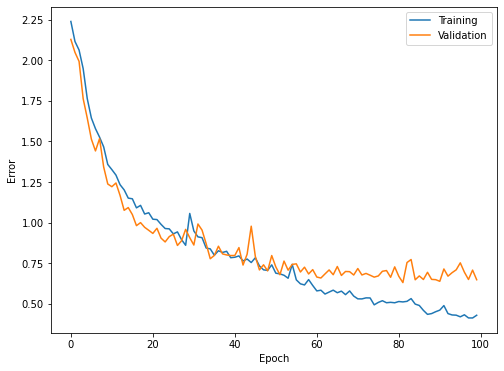

In [ ]:
# Plot training and validation loss
x_axis = range(num_epochs)
plt.figure(figsize=(8,6))
plt.plot(x_axis,loss_training)
plt.plot(x_axis,loss_validation)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training','Validation'));
plt.savefig('training and validation loss')

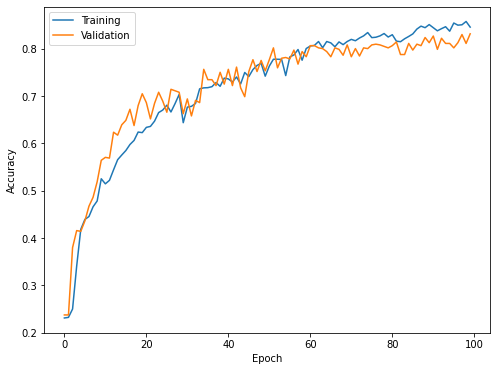

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(x_axis,acc_training)
plt.plot(x_axis,acc_validation)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training','Validation'));
plt.savefig('training and validation accuracy')

Confusion matrix
The confusion matrix allows us to visualize how well is predicted each class and which are the most common misclassifications.

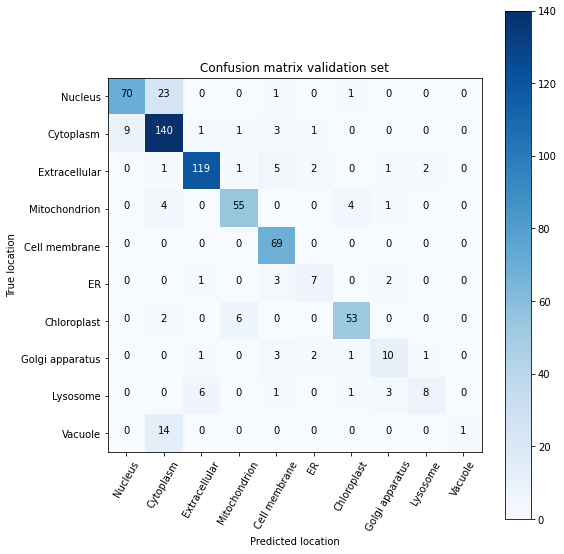

In [ ]:
# Plot confusion matrix 
# Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

plt.figure(figsize=(8,8))
cmap=plt.cm.Blues   
plt.imshow(cf_val, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = cf_val.max() / 2.
for i, j in itertools.product(range(cf_val.shape[0]), range(cf_val.shape[1])):
    plt.text(j, i, cf_val[i, j],
             horizontalalignment="center",
             color="white" if cf_val[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location');
plt.savefig('Confusion matrix validation set')

In [ ]:
batch_size_1=X_val.shape[0]

In [ ]:
_, val_fn_cnn_lstm, cnn_lstm_params_batch1 = CNN_LSTM(batch_size_1, seq_len, n_hid, n_feat, n_class, n_filt, lr, drop_prob)

In [ ]:
with np.load('/content/subcellular_localization/notebook tutorial/params/CNN-LSTM_params.npz') as f:
    param_values = [f['arr_%d' % i].astype(np.float32) for i in range(len(f.files))]
lasagne.layers.set_all_param_values(cnn_lstm_params_batch1, param_values)


In [ ]:
# Initialize confusion matrix
confusion_cnn_lstm_val = ConfusionMatrix(n_class)
# Perform prediction
err_cnn_lstm_val, predict_cnn_lstm_val = val_fn_cnn_lstm(
    X_val.astype(np.float32), y_val.astype(np.int32), mask_val.astype(np.float32))
preds_cnn_lstm_val = np.argmax(predict_cnn_lstm_val, axis=-1)
# Calculate accuracy
confusion_cnn_lstm_val.batch_add(y_val, preds_cnn_lstm_val)
cnn_lstm_accuracy_val = confusion_cnn_lstm_val.accuracy()
cf_cnn_lstm_val = confusion_cnn_lstm_val.ret_mat()

In [ ]:
cnn_lstm_accuracy_val

0.8125984251968504

In [ ]:
cnn_lstm_gorodkin_val=gorodkin(cf_cnn_lstm_val)
cnn_lstm_gorodkin_val

0.7783528136602552

In [ ]:
batch_size_2=X_train.shape[0]

In [ ]:
train_fn_cnn_lstm, _, cnn_lstm_params_batch2 = CNN_LSTM(batch_size_2, seq_len, n_hid, n_feat, n_class, n_filt, lr, drop_prob)

In [ ]:
with np.load('/content/subcellular_localization/notebook tutorial/params/CNN-LSTM_params.npz') as f:
    param_values = [f['arr_%d' % i].astype(np.float32) for i in range(len(f.files))]
lasagne.layers.set_all_param_values(cnn_lstm_params_batch2, param_values)

In [ ]:
# Initialize confusion matrix
confusion_cnn_lstm_train = ConfusionMatrix(n_class)
# Perform prediction
err_cnn_lstm_train, predict_cnn_lstm_train = train_fn_cnn_lstm(
    X_train.astype(np.float32), y_train.astype(np.int32), mask_train.astype(np.float32))
preds_cnn_lstm_train = np.argmax(predict_cnn_lstm_train, axis=-1)
# Calculate accuracy
confusion_cnn_lstm_train.batch_add(y_train, preds_cnn_lstm_train)
cnn_lstm_accuracy_train = confusion_cnn_lstm_train.accuracy()
cf_cnn_lstm_train = confusion_cnn_lstm_train.ret_mat()

In [ ]:
cnn_lstm_accuracy_train

In [ ]:
cnn_lstm_gorodkin_train=gorodkin(cf_cnn_lstm_train)
cnn_lstm_gorodkin_train